In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
h5_annot_mouse = '../../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'
swan_file = '../swan/swan.p'
mouse_swan_file = '../../../mouse/lr_bulk/swan/swan.p'
ab = '../../talon/human_talon_abundance.tsv'
mouse_filt_ab = '../../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
major_set_mouse = '../swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()

In [32]:
ca = cerberus.read(h5_annot)
m_ca = cerberus.read(h5_annot_mouse)
sg = swan.read(swan_file)
m_sg = swan.read(mouse_swan_file)

Read in graph from ../swan/swan.p
Read in graph from ../../../mouse/lr_bulk/swan/swan.p


In [33]:
def get_human_mouse_gid_table():
    # get matching gids from human and mouse
    df = pd.read_csv('../../../refs/biomart_human_to_mouse.tsv', sep='\t')

    # drop nans in either human or mouse
    df = df[['Gene stable ID', 'Mouse gene stable ID']]
    df = df.loc[~df['Gene stable ID'].isnull()]
    df = df.loc[~df['Mouse gene stable ID'].isnull()]    
    
    df = df.drop_duplicates()
    return df

## Compare centroid for sample_det for each gene to sample_det in mouse

In [34]:
def get_human_df(ca):
    # compute centroid for each mm sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)&(ca.triplets['sample'].isin(mm_tissues))].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [35]:
def get_mouse_df(ca):
    # compute centroid for each mm sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='vM25_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [36]:
# compute centroid for each mm sample / gene pairing for the different sources
h_df = get_human_df(ca)
m_df = get_mouse_df(m_ca)

In [37]:
mh_df = get_human_mouse_gid_table()

In [38]:
# merge in mouse gids that we need
df = h_df.merge(mh_df, how='left', left_on='gid', right_on='Gene stable ID')

# merge in mouse data
df = df.merge(m_df, how='inner', left_on='Mouse gene stable ID', right_on='gid', suffixes=('_human', '_mouse'))

In [39]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_human', '_mouse'),
                               axis=1)

In [40]:
df.head()

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gname_mouse,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist
0,A1BG,ENSG00000121410,0.306397,0.427609,0.265993,1.444444,mixed,ENSG00000121410,protein_coding,ENSG00000121410,...,A1bg,ENSMUSG00000022347,0.333333,0.333333,0.333333,1.000000,simple,ENSMUSG00000022347,protein_coding,0.071462
1,A2M,ENSG00000175899,0.340071,0.197813,0.462116,5.166667,mixed,ENSG00000175899,protein_coding,ENSG00000175899,...,A2m,ENSMUSG00000030111,0.333333,0.333333,0.333333,1.000000,simple,ENSMUSG00000030111,protein_coding,0.118292
2,A4GALT,ENSG00000128274,0.335897,0.232508,0.431595,4.000000,mixed,ENSG00000128274,protein_coding,ENSG00000128274,...,A4galt,ENSMUSG00000047878,0.262843,0.402434,0.334723,1.846154,mixed,ENSMUSG00000047878,protein_coding,0.129663
3,AAAS,ENSG00000094914,0.239435,0.170247,0.590319,4.333333,splicing,ENSG00000094914,protein_coding,ENSG00000094914,...,Aaas,ENSMUSG00000036678,0.265591,0.265591,0.468817,1.935484,mixed,ENSMUSG00000036678,protein_coding,0.095331
4,AACS,ENSG00000081760,0.223280,0.175661,0.601058,4.333333,splicing,ENSG00000081760,protein_coding,ENSG00000081760,...,Aacs,ENSMUSG00000029482,0.310955,0.228864,0.460181,2.451613,mixed,ENSMUSG00000029482,protein_coding,0.100284


In [42]:
df.to_csv('sample_det_mouse_v_human_dist.tsv', sep='\t', index=False)

In [43]:
df.sort_values(by='dist', ascending=False)[['gname_human', 'dist', 'sector_human', 'sector_mouse']].head(40).tail(20)

,gname_human,dist,sector_human,sector_mouse
8897,NVL,0.358326,splicing,tes
3656,DPM1,0.357937,splicing,mixed
10110,PRDX5,0.357818,splicing,tss
6762,KLHL26,0.355603,tes,splicing
2236,CDK5RAP1,0.355557,splicing,mixed
3119,CWC22,0.354764,tes,splicing
12113,SLC5A6,0.353964,splicing,tss
1792,CAPN10,0.353642,splicing,mixed
5653,HADHA,0.352457,splicing,mixed
11549,SELENOW,0.352247,tss,splicing


## Looking at the results

In [3]:
df = pd.read_csv('sample_det_mouse_v_human_dist.tsv', sep='\t')

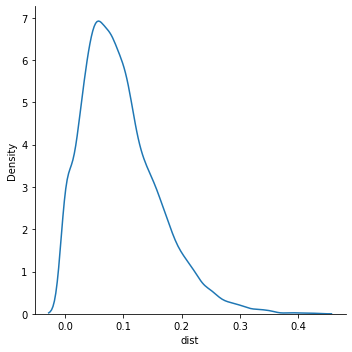

In [47]:
sns.displot(data=df, x='dist', kind='kde')

In [48]:
df = df.sort_values(by='dist', ascending=False)
df.index = [i for i in range(len(df.index))]
df.loc[df.gname_human=='ARF4']

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gname_mouse,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist
34,ARF4,ENSG00000168374,0.206614,0.206614,0.586772,3.111111,splicing,ENSG00000168374,protein_coding,ENSG00000168374,...,Arf4,ENSMUSG00000021877,0.315754,0.547987,0.136259,3.387097,tes,ENSMUSG00000021877,protein_coding,0.348437


In [51]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 0.2
n = len(df.index)
n_num = len(df.loc[df.dist >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a distance >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

7.26% of protein-coding genes in mouse and human (1108/15258) have a distance >= 0.2 between species


In [52]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 0.3
n = len(df.index)
n_num = len(df.loc[df.dist >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a distance >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

0.82% of protein-coding genes in mouse and human (125/15258) have a distance >= 0.3 between species


In [55]:
# calc z scores and use these to quantiy
df['z_score'] = st.zscore(df.dist.tolist())

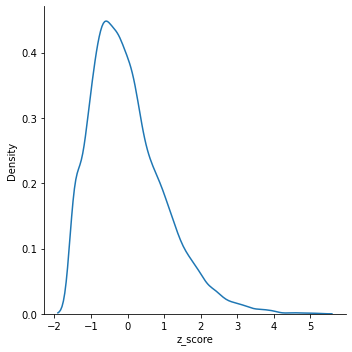

In [57]:
sns.displot(data=df, x='z_score', kind='kde')

In [59]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 2
n = len(df.index)
n_num = len(df.loc[df.z_score >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a zscore >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

4.23% of protein-coding genes in mouse and human (646/15258) have a zscore >= 2 between species


In [60]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 3
n = len(df.index)
n_num = len(df.loc[df.z_score >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a zscore >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

1.06% of protein-coding genes in mouse and human (162/15258) have a zscore >= 3 between species


In [61]:
df.loc[df.gname_human == 'ARF4']

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist,z_score
774,ARF4,ENSG00000168374,0.206614,0.206614,0.586772,3.111111,splicing,ENSG00000168374,protein_coding,ENSG00000168374,...,ENSMUSG00000021877,0.315754,0.547987,0.136259,3.387097,tes,ENSMUSG00000021877,protein_coding,0.348437,3.911538


## GO on z-scores >= 3

In [6]:
thresh = 3
opref = 'human_mouse_z_score_genes_{}'.format(thresh)
df = df.loc[df.z_score >= thresh]
gids = df.gid_human.tolist()

In [7]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]


desc = opref
odir = '{}_genes_GO'.format(opref)
gids = bm.query(dataset='hsapiens_gene_ensembl',
       attributes=['ensembl_gene_id', 'external_gene_name'],
       filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description=desc,
                outdir=odir,
                cutoff=0.5)

In [62]:
df.to_csv('sample_det_mouse_v_human_dist.tsv', sep='\t', index=False)

In [23]:
def plot_human_mouse(ca, m_ca, df, gene):
    
    # get mouse gene name
    gene_mouse = df.loc[df.gname_human==gene, 'gname_mouse'].values[0]

    # human
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'} 
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    subset = {'source': ['v40', 'obs_mm_det', 'sample_det']}

    # can't subset the way that I want because I want to use and and or logic...
    ca.triplets = ca.triplets.loc[ca.triplets.source.isin(subset['source'])]
    ca.triplets = ca.triplets.loc[ca.triplets['sample'].isin(mm_tissues)]
    
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det']},
                size_scale=0.5,
                fname='figures/simplex_{}.pdf'.format(gene.lower()))

    # mouse
    c_dict, order = get_lr_bulk_sample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'vM25': '*', 'obs_det': '^', 'cerberus': '2'}
    subset = {'source': ['vM25', 'obs_det', 'sample_det']}
    df = m_ca.plot_simplex(top='splicing_ratio', 
                gene=gene_mouse,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det']},
                size_scale=0.5,
                fname='figures/simplex_mouse_{}.pdf'.format(gene.lower()))

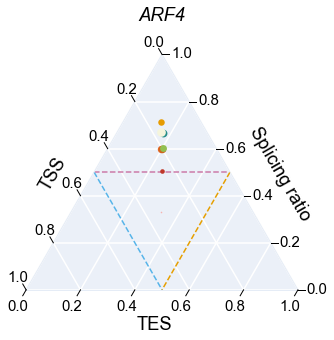

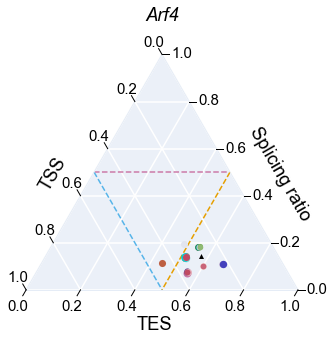

In [24]:
plot_human_mouse(ca, m_ca, df, 'ARF4')

In [10]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='ARF4')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
22776,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,ARF4,brain,88.595078
146030,sample_det,ENSG00000168374,1.0,1.0,4.0,4.0,4.0,ARF4,pgp1_astro,326.434998
233010,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,ARF4,h1,240.441605
287330,sample_det,ENSG00000168374,1.0,1.0,1.0,1.0,1.0,ARF4,muscle,26.309940
310874,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,ARF4,wtc11,240.854675
396004,sample_det,ENSG00000168374,1.0,1.0,2.0,2.0,2.0,ARF4,heart,58.211140
542445,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,ARF4,pgp1_excite_neuron,174.750427
555578,sample_det,ENSG00000168374,1.0,1.0,5.0,5.0,5.0,ARF4,adrenal gland,142.368027
576900,sample_det,ENSG00000168374,1.0,1.0,4.0,4.0,4.0,ARF4,h9_osteocyte,572.059448


In [11]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Arf4')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
79725,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,Arf4,adrenal,192.309082,NaN
79726,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,Arf4,adrenal_10d,191.445343,NaN
79727,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,4.0,0.800000,Arf4,adrenal_14d,186.728561,NaN
79728,sample_det,ENSMUSG00000021877,1.0,2.0,1.0,2.0,0.666667,Arf4,adrenal_18-20mo,146.663651,NaN
79729,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,Arf4,adrenal_25d,196.478851,NaN
79730,sample_det,ENSMUSG00000021877,2.0,2.0,1.0,3.0,0.500000,Arf4,adrenal_2mo,196.195892,NaN
79731,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,Arf4,adrenal_36d,171.244308,NaN
79732,sample_det,ENSMUSG00000021877,2.0,4.0,2.0,5.0,0.666667,Arf4,adrenal_4d,190.771164,NaN
79733,sample_det,ENSMUSG00000021877,2.0,3.0,1.0,5.0,0.400000,Arf4,c2c12_myoblast,351.628815,NaN
79734,sample_det,ENSMUSG00000021877,1.0,2.0,1.0,2.0,0.666667,Arf4,c2c12_myotube,146.246033,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


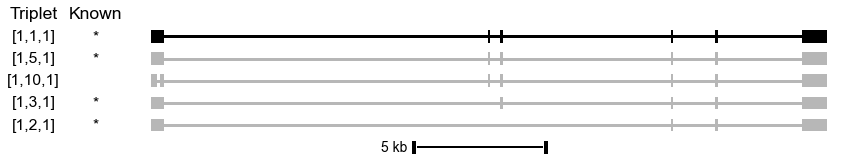

In [12]:
gene = 'ARF4'
obs_col = 'sample'
obs_condition = 'adrenal gland'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

In [15]:
m_sg.adata.obs['sample'].unique()

array(['hippocampus_18-20mo', 'cortex_18-20mo', 'adrenal_18-20mo',
       'adrenal_10d', 'hippocampus_14d', 'cortex', 'heart_18-20mo',
       'adrenal', 'adrenal_4d', 'hippocampus_2mo', 'gastroc_36d',
       'hippocampus', 'c2c12_myotube', 'gastroc_4d', 'f1219',
       'adrenal_2mo', 'gastroc_14d', 'gastroc_25d', 'cortex_14d',
       'gastroc_18-20mo', 'gastroc_2mo', 'gastroc_10d', 'adrenal_36d',
       'adrenal_25d', 'cortex_2mo', 'adrenal_14d', 'c2c12_myoblast',
       'heart_2mo', 'forelimb_e11', 'heart_14d', 'forelimb_e13'],
      dtype=object)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


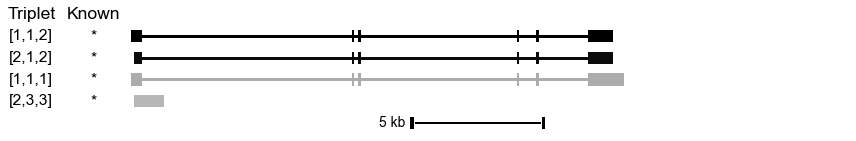

In [18]:
gene = 'Arf4'
obs_col = 'sample'
obs_condition = 'adrenal_14d'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


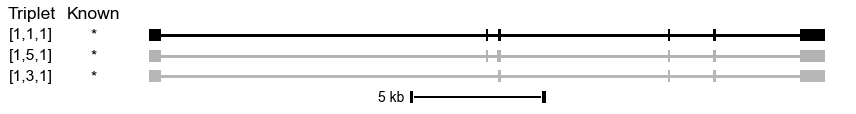

In [21]:
gene = 'ARF4'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')
fname = 'figures/{}_{}_human_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


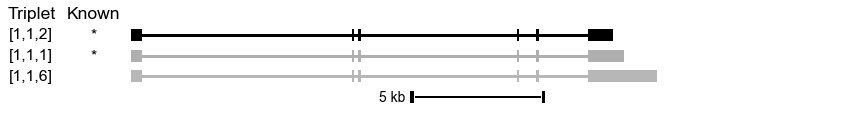

In [22]:
gene = 'Arf4'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')
fname = 'figures/{}_{}_mouse_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


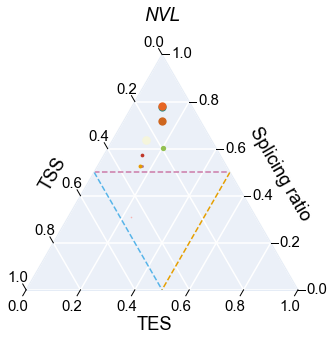

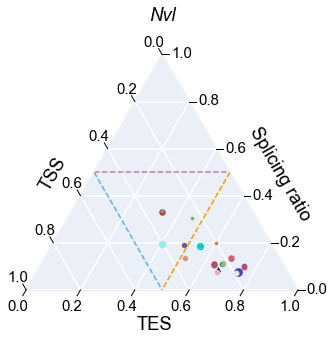

In [56]:
plot_human_mouse(ca, m_ca, df, 'NVL')

In [57]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='NVL')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
19917,sample_det,ENSG00000143748,2.0,1.0,5.0,6.0,3.333333,NVL,brain,7.298236
143664,sample_det,ENSG00000143748,1.0,1.0,7.0,7.0,7.000000,NVL,pgp1_astro,53.763508
230344,sample_det,ENSG00000143748,1.0,1.0,7.0,7.0,7.000000,NVL,h1,56.439419
285150,sample_det,ENSG00000143748,2.0,1.0,2.0,2.0,1.333333,NVL,muscle,6.049005
308272,sample_det,ENSG00000143748,1.0,1.0,5.0,5.0,5.000000,NVL,wtc11,56.325283
393120,sample_det,ENSG00000143748,2.0,1.0,6.0,7.0,4.000000,NVL,heart,8.900148
540432,sample_det,ENSG00000143748,1.0,1.0,3.0,3.0,3.000000,NVL,pgp1_excite_neuron,14.382305
553052,sample_det,ENSG00000143748,2.0,1.0,5.0,6.0,3.333333,NVL,adrenal gland,9.328543
575070,sample_det,ENSG00000143748,2.0,1.0,8.0,9.0,5.333333,NVL,h9_osteocyte,68.538826


In [58]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Nvl')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
131313,sample_det,ENSMUSG00000026516,1.0,1.0,1.0,1.0,1.000000,Nvl,adrenal,40.409588,NaN
131314,sample_det,ENSMUSG00000026516,2.0,4.0,3.0,6.0,1.000000,Nvl,adrenal_10d,23.041965,NaN
131315,sample_det,ENSMUSG00000026516,1.0,3.0,1.0,3.0,0.500000,Nvl,adrenal_14d,21.348690,NaN
131316,sample_det,ENSMUSG00000026516,1.0,2.0,1.0,2.0,0.666667,Nvl,adrenal_18-20mo,17.716255,NaN
131317,sample_det,ENSMUSG00000026516,2.0,4.0,3.0,4.0,1.000000,Nvl,adrenal_25d,22.623215,NaN
131318,sample_det,ENSMUSG00000026516,1.0,2.0,2.0,3.0,1.333333,Nvl,adrenal_2mo,20.348509,NaN
131319,sample_det,ENSMUSG00000026516,2.0,4.0,3.0,4.0,1.000000,Nvl,adrenal_36d,9.906714,NaN
131320,sample_det,ENSMUSG00000026516,2.0,4.0,3.0,5.0,1.000000,Nvl,adrenal_4d,21.899826,NaN
131321,sample_det,ENSMUSG00000026516,1.0,5.0,2.0,5.0,0.666667,Nvl,c2c12_myoblast,41.926422,NaN
131322,sample_det,ENSMUSG00000026516,1.0,4.0,2.0,4.0,0.800000,Nvl,c2c12_myotube,22.477871,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


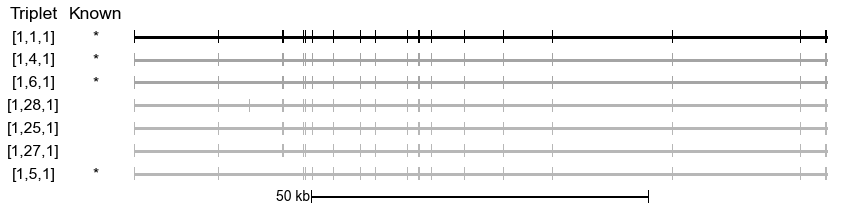

In [59]:
gene = 'NVL'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


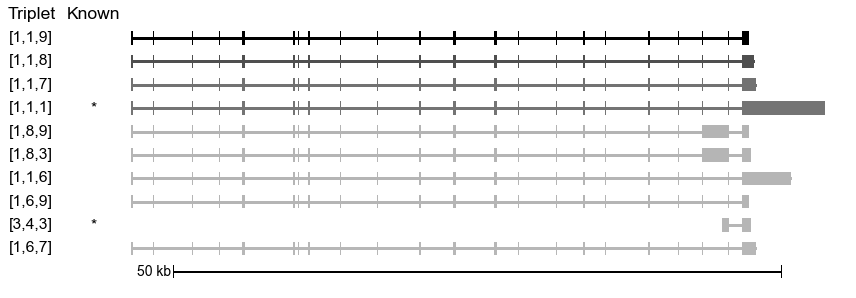

In [60]:
gene = 'Nvl'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


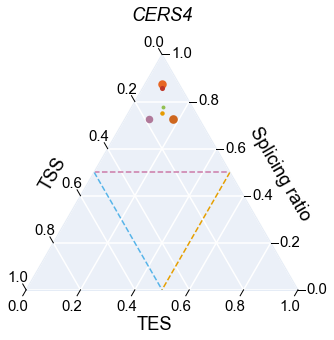

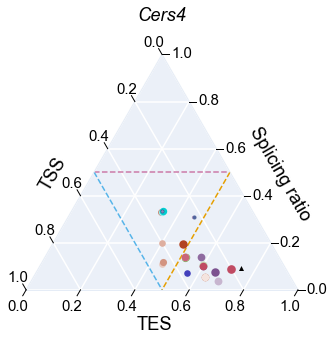

In [16]:
plot_human_mouse(ca, m_ca, df, 'CERS4')

In [27]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='CERS4')]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


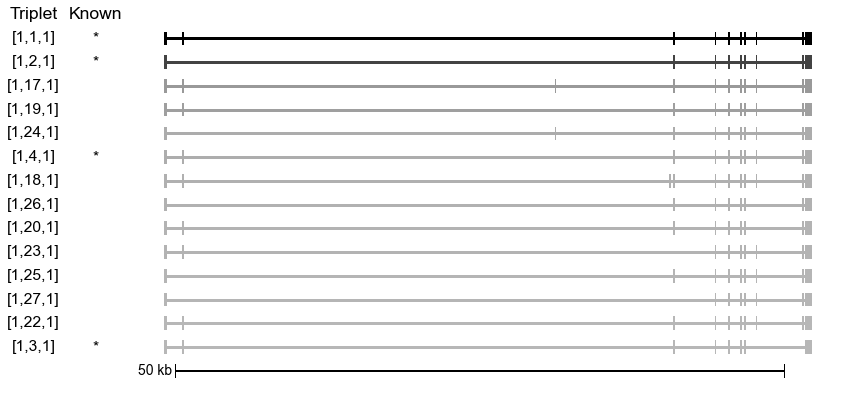

In [18]:
gene = 'CERS4'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

In [26]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Cers4')]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


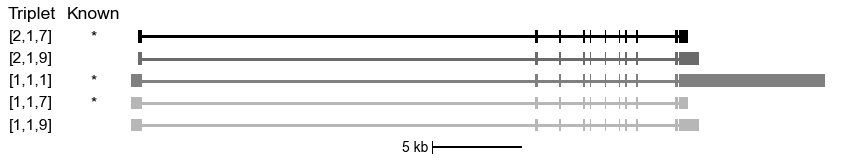

In [22]:
gene = 'Cers4'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


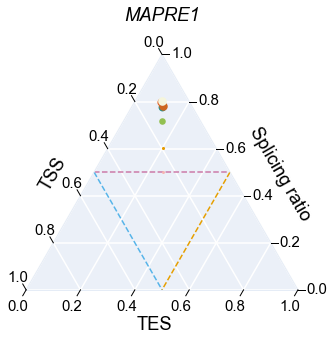

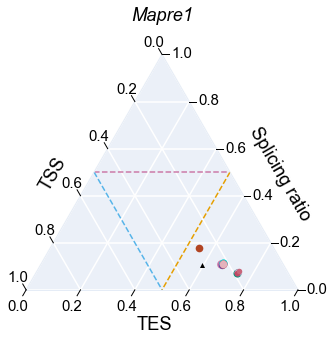

In [29]:
plot_human_mouse(ca, m_ca, df, 'MAPRE1')

In [30]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='M2APRE1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
15264,sample_det,ENSG00000101367,1.0,1.0,7.0,7.0,7.0,MAPRE1,brain,42.799232
139607,sample_det,ENSG00000101367,1.0,1.0,7.0,7.0,7.0,MAPRE1,pgp1_astro,251.871246
225908,sample_det,ENSG00000101367,1.0,1.0,8.0,8.0,8.0,MAPRE1,h1,292.721649
281391,sample_det,ENSG00000101367,1.0,1.0,2.0,2.0,2.0,MAPRE1,muscle,51.873417
303926,sample_det,ENSG00000101367,1.0,1.0,7.0,7.0,7.0,MAPRE1,wtc11,341.398773
388372,sample_det,ENSG00000101367,1.0,1.0,8.0,8.0,8.0,MAPRE1,heart,114.594849
536996,sample_det,ENSG00000101367,1.0,1.0,5.0,5.0,5.0,MAPRE1,pgp1_excite_neuron,145.072159
548776,sample_det,ENSG00000101367,1.0,1.0,3.0,3.0,3.0,MAPRE1,adrenal gland,53.161201
571881,sample_det,ENSG00000101367,1.0,1.0,8.0,8.0,8.0,MAPRE1,h9_osteocyte,376.381287


In [34]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Mapre1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
143723,sample_det,ENSMUSG00000027479,2.0,2.0,3.0,4.0,1.500000,Mapre1,adrenal,262.349823,NaN
143724,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,9.0,1.333333,Mapre1,adrenal_10d,150.297440,NaN
143725,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,8.0,1.333333,Mapre1,adrenal_14d,138.793182,NaN
143726,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,7.0,1.333333,Mapre1,adrenal_18-20mo,145.697968,NaN
143727,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,8.0,1.333333,Mapre1,adrenal_25d,125.229904,NaN
143728,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,8.0,1.333333,Mapre1,adrenal_2mo,149.370071,NaN
143729,sample_det,ENSMUSG00000027479,2.0,4.0,3.0,6.0,1.000000,Mapre1,adrenal_36d,112.144188,NaN
143730,sample_det,ENSMUSG00000027479,2.0,4.0,3.0,6.0,1.000000,Mapre1,adrenal_4d,164.450104,NaN
143731,sample_det,ENSMUSG00000027479,2.0,4.0,4.0,9.0,1.333333,Mapre1,c2c12_myoblast,468.949860,NaN
143732,sample_det,ENSMUSG00000027479,3.0,6.0,5.0,10.0,1.111111,Mapre1,c2c12_myotube,338.628296,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


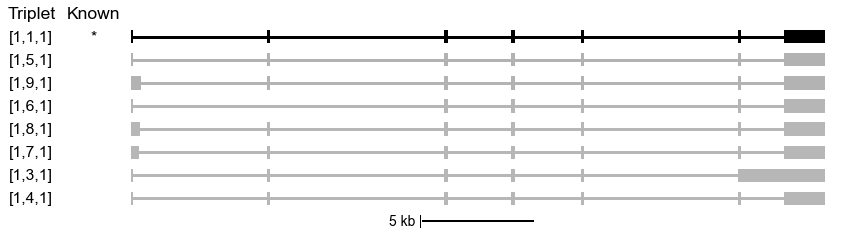

In [35]:
gene = 'MAPRE1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


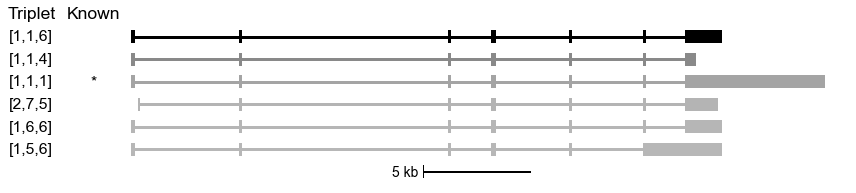

In [36]:
gene = 'Mapre1'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


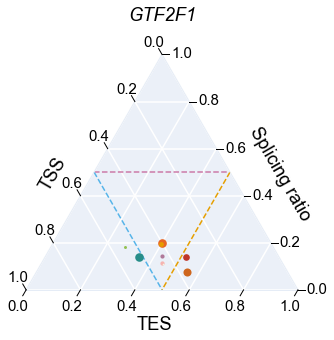

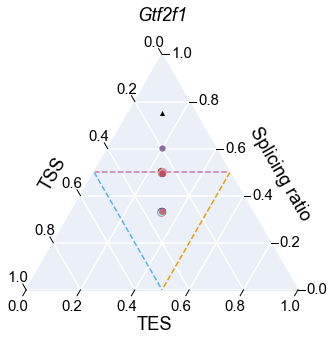

In [37]:
plot_human_mouse(ca, m_ca, df, 'GTF2F1')

In [38]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='GTF2F1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
17762,sample_det,ENSG00000125651,3.0,3.0,3.0,7.0,1.000000,GTF2F1,brain,53.877850
141793,sample_det,ENSG00000125651,3.0,2.0,2.0,5.0,0.800000,GTF2F1,pgp1_astro,87.874786
228301,sample_det,ENSG00000125651,2.0,2.0,2.0,5.0,1.000000,GTF2F1,h1,89.037720
283422,sample_det,ENSG00000125651,2.0,2.0,1.0,3.0,0.500000,GTF2F1,muscle,54.130547
306275,sample_det,ENSG00000125651,2.0,3.0,1.0,5.0,0.400000,GTF2F1,wtc11,81.823929
390926,sample_det,ENSG00000125651,2.0,3.0,2.0,6.0,0.800000,GTF2F1,heart,68.331055
538857,sample_det,ENSG00000125651,2.0,1.0,1.0,2.0,0.666667,GTF2F1,pgp1_excite_neuron,49.996223
551101,sample_det,ENSG00000125651,2.0,2.0,2.0,4.0,1.000000,GTF2F1,adrenal gland,57.273571
573625,sample_det,ENSG00000125651,2.0,2.0,1.0,4.0,0.500000,GTF2F1,h9_osteocyte,47.274563


In [39]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Gtf2f1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
11891,sample_det,ENSMUSG00000002658,1.0,1.0,5.0,5.0,5.0,Gtf2f1,adrenal,95.046188,NaN
11892,sample_det,ENSMUSG00000002658,1.0,1.0,5.0,5.0,5.0,Gtf2f1,adrenal_10d,91.813988,NaN
11893,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,adrenal_14d,104.592499,NaN
11894,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,adrenal_18-20mo,116.201088,NaN
11895,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,adrenal_25d,102.189789,NaN
11896,sample_det,ENSMUSG00000002658,1.0,1.0,5.0,5.0,5.0,Gtf2f1,adrenal_2mo,108.860428,NaN
11897,sample_det,ENSMUSG00000002658,1.0,1.0,5.0,5.0,5.0,Gtf2f1,adrenal_36d,104.206642,NaN
11898,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,adrenal_4d,136.320084,NaN
11899,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,c2c12_myoblast,216.933014,NaN
11900,sample_det,ENSMUSG00000002658,1.0,1.0,6.0,6.0,6.0,Gtf2f1,c2c12_myotube,113.257202,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


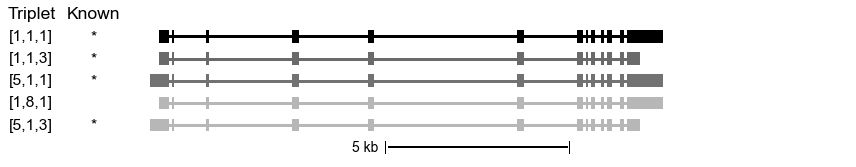

In [40]:
gene = 'GTF2F1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


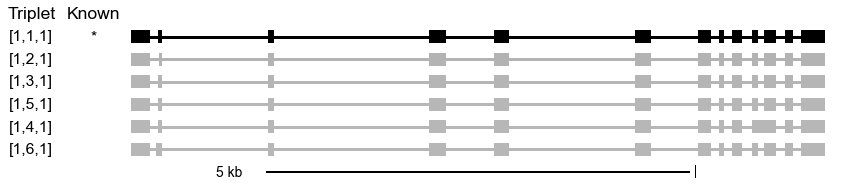

In [41]:
gene = 'Gtf2f1'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


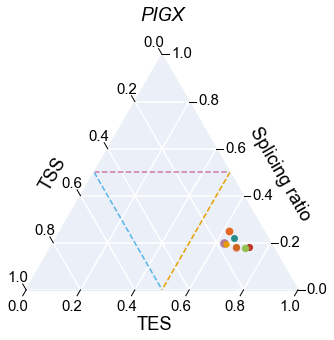

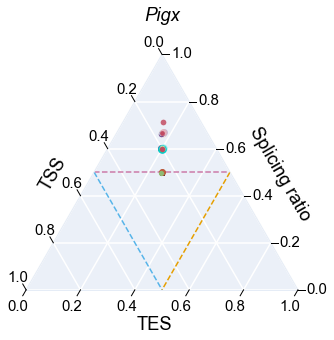

In [42]:
plot_human_mouse(ca, m_ca, df, 'PIGX')

In [43]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='PIGX')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
21926,sample_det,ENSG00000163964,2.0,7.0,10.0,20.0,2.222222,PIGX,brain,59.616425
145335,sample_det,ENSG00000163964,1.0,5.0,5.0,6.0,1.666667,PIGX,pgp1_astro,24.473745
232226,sample_det,ENSG00000163964,1.0,5.0,6.0,9.0,2.000000,PIGX,h1,36.134960
286685,sample_det,ENSG00000163964,1.0,5.0,4.0,5.0,1.333333,PIGX,muscle,34.326485
310109,sample_det,ENSG00000163964,1.0,5.0,4.0,9.0,1.333333,PIGX,wtc11,26.056576
395159,sample_det,ENSG00000163964,1.0,8.0,9.0,18.0,2.000000,PIGX,heart,26.838938
541845,sample_det,ENSG00000163964,1.0,7.0,7.0,11.0,1.750000,PIGX,pgp1_excite_neuron,30.026512
554831,sample_det,ENSG00000163964,1.0,4.0,3.0,5.0,1.200000,PIGX,adrenal gland,18.396997
576370,sample_det,ENSG00000163964,1.0,1.0,1.0,1.0,1.000000,PIGX,h9_osteocyte,5.031843


In [44]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Pigx')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
98154,sample_det,ENSMUSG00000023791,1.0,1.0,4.0,4.0,4.0,Pigx,adrenal,32.876873,NaN
98155,sample_det,ENSMUSG00000023791,1.0,1.0,6.0,6.0,6.0,Pigx,adrenal_10d,45.798637,NaN
98156,sample_det,ENSMUSG00000023791,1.0,1.0,6.0,6.0,6.0,Pigx,adrenal_14d,36.805126,NaN
98157,sample_det,ENSMUSG00000023791,1.0,1.0,4.0,4.0,4.0,Pigx,adrenal_18-20mo,19.640165,NaN
98158,sample_det,ENSMUSG00000023791,2.0,2.0,6.0,6.0,3.0,Pigx,adrenal_25d,20.011906,NaN
98159,sample_det,ENSMUSG00000023791,1.0,1.0,5.0,5.0,5.0,Pigx,adrenal_2mo,26.373880,NaN
98160,sample_det,ENSMUSG00000023791,1.0,1.0,6.0,6.0,6.0,Pigx,adrenal_36d,41.672867,NaN
98161,sample_det,ENSMUSG00000023791,1.0,1.0,7.0,7.0,7.0,Pigx,adrenal_4d,45.959930,NaN
98162,sample_det,ENSMUSG00000023791,1.0,1.0,6.0,6.0,6.0,Pigx,c2c12_myoblast,28.206461,NaN
98163,sample_det,ENSMUSG00000023791,1.0,1.0,5.0,5.0,5.0,Pigx,c2c12_myotube,31.388069,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


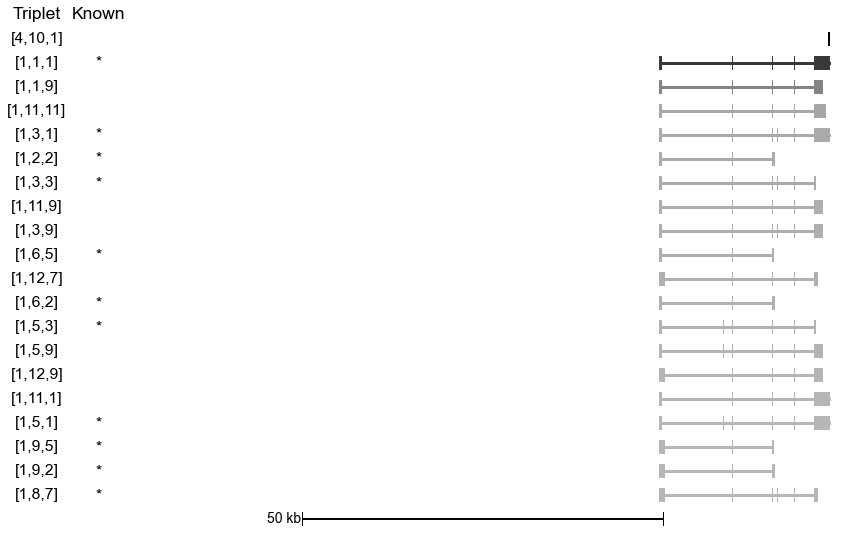

In [45]:
gene = 'PIGX'
obs_col = 'sample'
obs_condition = 'brain'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


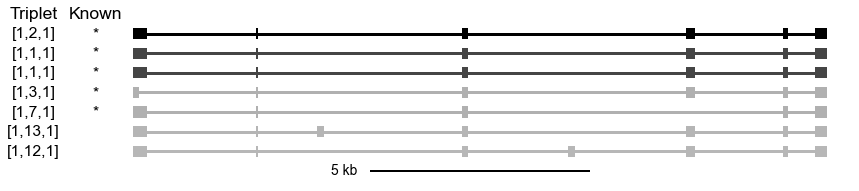

In [46]:
obs_condition = 'cortex_14d'
gene = 'Pigx'
obs_col = 'sample'
obs_condition = 'cortex_14d'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


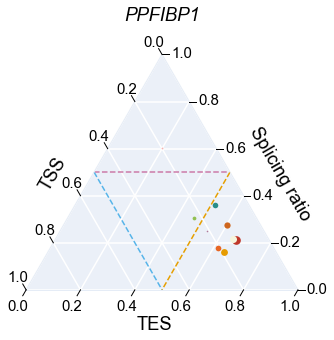

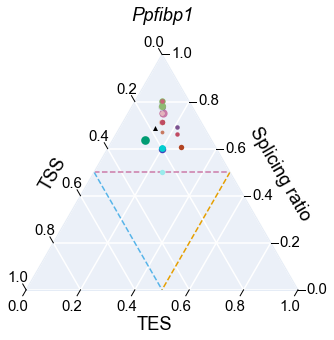

In [47]:
plot_human_mouse(ca, m_ca, df, 'PPFIBP1')

In [48]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='PPFIBP1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
16309,sample_det,ENSG00000110841,2.0,5.0,8.0,10.0,2.285714,PPFIBP1,brain,10.495631
140516,sample_det,ENSG00000110841,1.0,4.0,7.0,10.0,2.800000,PPFIBP1,pgp1_astro,26.966486
226913,sample_det,ENSG00000110841,2.0,6.0,7.0,11.0,1.750000,PPFIBP1,h1,28.156063
282244,sample_det,ENSG00000110841,1.0,1.0,3.0,3.0,3.000000,PPFIBP1,muscle,10.751463
304902,sample_det,ENSG00000110841,1.0,5.0,7.0,11.0,2.333333,PPFIBP1,wtc11,35.113205
389437,sample_det,ENSG00000110841,2.0,11.0,23.0,40.0,3.538462,PPFIBP1,heart,115.401634
537785,sample_det,ENSG00000110841,1.0,2.0,2.0,2.0,1.333333,PPFIBP1,pgp1_excite_neuron,15.442938
549744,sample_det,ENSG00000110841,2.0,7.0,8.0,9.0,1.777778,PPFIBP1,adrenal gland,45.578888
572563,sample_det,ENSG00000110841,1.0,5.0,5.0,5.0,1.666667,PPFIBP1,h9_osteocyte,49.806503


In [49]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Ppfibp1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tissue
41594,sample_det,ENSMUSG00000016487,1.0,1.0,6.0,6.0,6.000000,Ppfibp1,adrenal,37.243462,NaN
41595,sample_det,ENSMUSG00000016487,1.0,1.0,9.0,9.0,9.000000,Ppfibp1,adrenal_10d,35.695862,NaN
41596,sample_det,ENSMUSG00000016487,2.0,1.0,10.0,10.0,6.666667,Ppfibp1,adrenal_14d,34.979542,NaN
41597,sample_det,ENSMUSG00000016487,1.0,2.0,9.0,9.0,6.000000,Ppfibp1,adrenal_18-20mo,36.227493,NaN
41598,sample_det,ENSMUSG00000016487,1.0,1.0,10.0,10.0,10.000000,Ppfibp1,adrenal_25d,32.585938,NaN
41599,sample_det,ENSMUSG00000016487,1.0,1.0,10.0,10.0,10.000000,Ppfibp1,adrenal_2mo,31.343575,NaN
41600,sample_det,ENSMUSG00000016487,1.0,1.0,7.0,7.0,7.000000,Ppfibp1,adrenal_36d,18.689583,NaN
41601,sample_det,ENSMUSG00000016487,2.0,1.0,10.0,10.0,6.666667,Ppfibp1,adrenal_4d,42.187599,NaN
41602,sample_det,ENSMUSG00000016487,1.0,2.0,15.0,15.0,10.000000,Ppfibp1,c2c12_myoblast,201.647049,NaN
41603,sample_det,ENSMUSG00000016487,2.0,1.0,14.0,14.0,9.333333,Ppfibp1,c2c12_myotube,276.286743,NaN


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


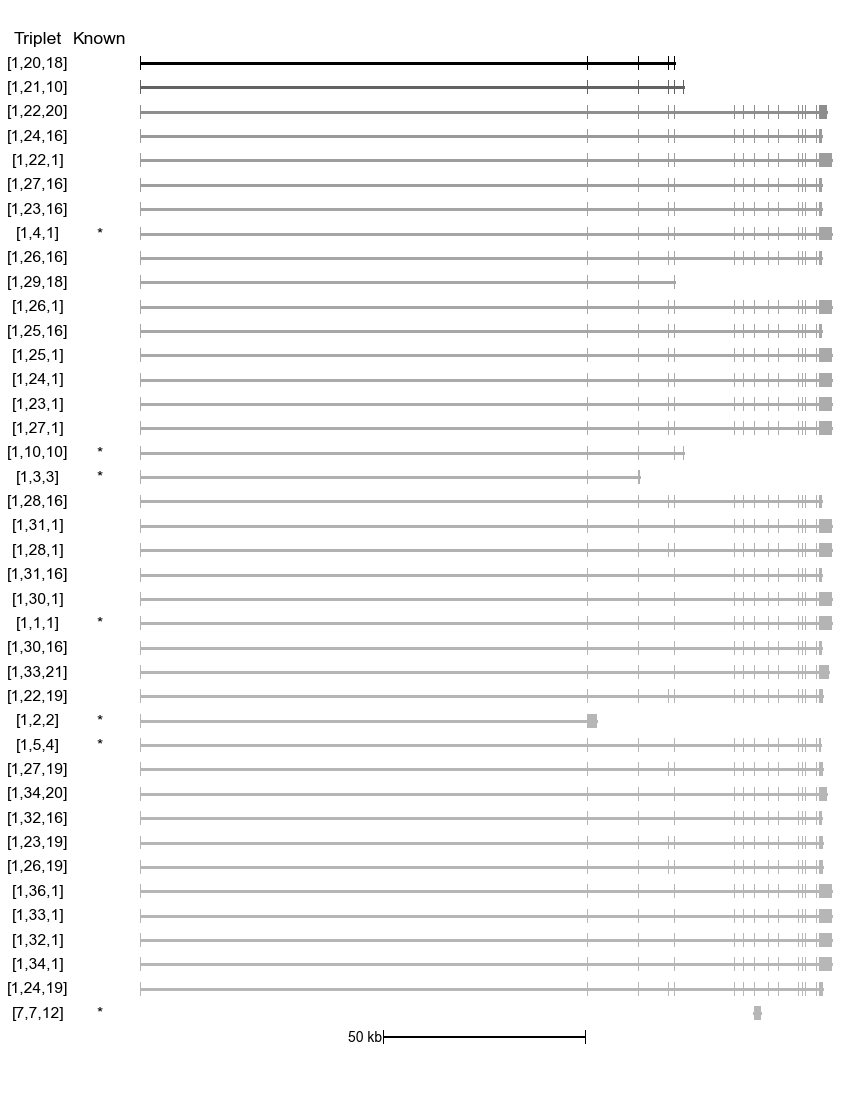

In [51]:
gene = 'PPFIBP1'
obs_col = 'sample'
obs_condition = 'heart'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


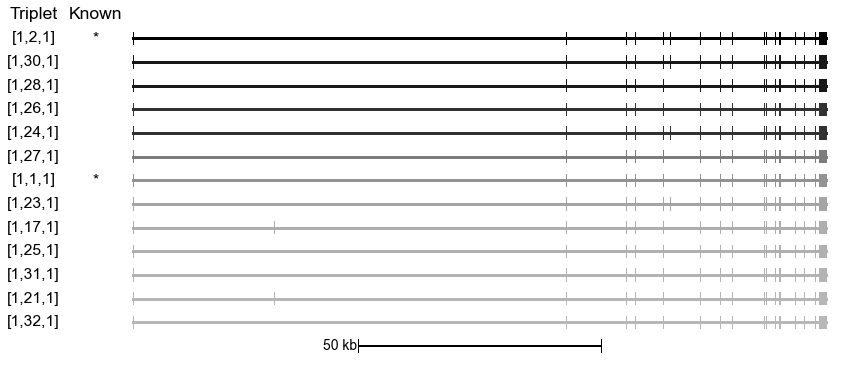

In [52]:
gene = 'Ppfibp1'
obs_col = 'sample'
obs_condition = 'heart_2mo'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')